In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from patch_extraction import *
import matplotlib.pyplot as plt

from VAE.models.vanilla_vae import VanillaVAE


In [3]:
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np

class SelectStrongestGradientPatch:
    def __init__(self, patch_size=256):
        self.patch_size = patch_size

    def __call__(self, img):
        gray = transforms.functional.to_grayscale(img, num_output_channels=1)
        tensor = transforms.functional.to_tensor(gray).unsqueeze(0)

        sobel_x = torch.tensor([[[-1,0,1],[-2,0,2],[-1,0,1]]], dtype=torch.float32).unsqueeze(0)
        sobel_y = torch.tensor([[[-1,-2,-1],[0,0,0],[1,2,1]]], dtype=torch.float32).unsqueeze(0)

        grad = torch.sqrt(F.conv2d(tensor, sobel_x, padding=1)**2 + F.conv2d(tensor, sobel_y, padding=1)**2)

        _, _, H, W = grad.shape
        crop_h, crop_w = min(self.patch_size, H), min(self.patch_size, W)

        if H < self.patch_size or W < self.patch_size:
            top, left = 0, 0
        else:
            stride = self.patch_size // 4
            grad_sums = F.avg_pool2d(grad, kernel_size=self.patch_size, stride=stride) * (self.patch_size**2)
            idx = torch.argmax(grad_sums)
            idx_h = (idx // grad_sums.shape[-1]) * stride
            idx_w = (idx % grad_sums.shape[-1]) * stride
            top, left = idx_h.item(), idx_w.item()

        return transforms.functional.crop(img, top=top, left=left, height=crop_h, width=crop_w)

In [ ]:
# Définir le prétraitement des images
transform = transforms.Compose([
    SelectStrongestGradientPatch(patch_size=64),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Charger toutes les images depuis les sous-dossiers de Data/
def get_data_loader(root_dir, batch_size=64):
    # Charger les images depuis le dossier racine
    dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    # Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    # Utiliser random_split pour séparer les données

    
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Créer le DataLoader pour l'entraînement et le test
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Exemple d'utilisation
root_dir = '../Data'  # Dossier racine où tous les peintres sont stockés dans des sous-dossiers
train_loader, test_loader = get_data_loader(root_dir)

# Vérification : afficher le batch size et la taille des images pour l'entraînement
for data, labels in train_loader:
    print(f"Batch size: {data.size(0)} - Image size: {data.size(2)} x {data.size(3)}")
    break

Batch size: 16 - Image size: 64 x 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.5058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


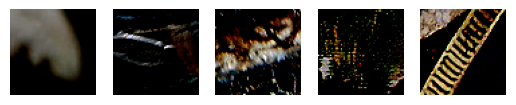

In [5]:

# Plot 5 random images from the test dataset (color images)
def plot_random_images(test_loader):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Plot 5 random images from the batch
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) for RGB display
        plt.axis('off')
    
    plt.show()

plot_random_images(test_loader)



In [6]:
'(''''class Encoder(nn.Module):
    def __init__(self, latent_dim=10, multiplier=1):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim
        self.multiplier = multiplier

        # Sequential block for the convolutional layers and batch normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(2*2*256, 512),
            nn.Linear(512, self.latent_dim * self.multiplier)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)  # Pass through fully connected layers
        
        # Reshape output depending on multiplier
        if self.multiplier == 1:
            return x.view(x.size(0), self.latent_dim)
        else:
            return x.view(x.size(0), self.latent_dim, self.multiplier)


class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2*2*256)
        )

        # Transposed convolutional layers
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
        )

    def forward(self, z):
        z = self.fc_layers(z)  # Pass through fully connected layers
        z = z.view(z.size(0), 256, 2, 2)  # Reshape for transpose convolutions
        z = self.conv_layers(z)  # Pass through transposed convolutional layers
        return torch.sigmoid(z)  # Output RGB image with sigmoid activation


class VAEModel(nn.Module):
    def __init__(self, latent_dim):
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, 2)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mean, logvar, mode='sample'):
        if mode == 'sample':
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return mean + std * eps
        elif mode == 'mean':
            return mean
        else:
            raise ValueError(f"Unknown mode: {mode}")

    def forward(self, x, mode='sample'):
        stats_qzx = self.encoder(x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1), mode=mode)
        reconstructions = self.decoder(samples_qzx)
        return {
            'reconstructions': reconstructions,
            'stats_qzx': stats_qzx,
            'samples_qzx': samples_qzx
        }

    def sample_qzx(self, x):
        stats_qzx = self.encoder(x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1))
        return samples_qzx

    def sample_pz(self, N):
        return torch.randn(N, self.latent_dim, device=self.encoder.conv1.weight.device)

    def generate_samples(self, samples_pz=None, N=None):
        if samples_pz is None:
            if N is None:
                raise ValueError("samples_pz and N cannot be None at the same time.")
            samples_pz = self.sample_pz(N)
        generations = self.decoder(samples_pz)
        return {'generations': generations}


class BetaVAELoss(object):
    def __init__(self, beta):
        self.beta = beta

    def __call__(self, reconstructions, data, stats_qzx):
        stats_qzx = stats_qzx.unbind(-1)
        rec_loss = reconstruction_loss(reconstructions, data)
        kl_loss = kl_normal_loss(*stats_qzx)
        loss = rec_loss + self.beta * kl_loss
        return loss


def reconstruction_loss(reconstructions, data):
    """
    Calculates the reconstruction loss for a batch of data. I.e. negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (e.g. batch of images). Shape : (batch_size, 1,
        height, width).

    reconstructions : torch.Tensor
        Reconstructed data. Shape : (batch_size, 1, height, width).

    Returns
    -------
    loss : torch.Tensor
        Binary cross entropy, AVERAGED over images in the batch but SUMMED over
        pixel and channel.
    """
    loss = F.binary_cross_entropy(reconstructions, data, reduction='none')
    loss = loss.sum(dim=(1,2,3))
    return loss.mean()


    
def kl_normal_loss(mean, logvar):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mean : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    logvar : torch.Tensor
        Diagonal log variance of the normal distribution. Shape (batch_size,
        latent_dim)
    """

    latent_kl = 0.5 * (mean.pow(2) + logvar.exp() - 1 - logvar).sum(dim=1)  
    return latent_kl.mean()
 

'''''

'(class Encoder(nn.Module):\n    def __init__(self, latent_dim=10, multiplier=1):\n        super(Encoder, self).__init__()\n\n        self.latent_dim = latent_dim\n        self.multiplier = multiplier\n\n        # Sequential block for the convolutional layers and batch normalization\n        self.conv_layers = nn.Sequential(\n            nn.Conv2d(3, 32, 4, 2, 1),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n            nn.Conv2d(32, 64, 4, 2, 1),\n            nn.BatchNorm2d(64),\n            nn.ReLU(),\n            nn.Conv2d(64, 128, 4, 2, 1),\n            nn.BatchNorm2d(128),\n            nn.ReLU(),\n            nn.Conv2d(128, 256, 4, 2, 1),\n            nn.BatchNorm2d(256),\n            nn.ReLU()\n        )\n\n        # Fully connected layers\n        self.fc_layers = nn.Sequential(\n            nn.Linear(2*2*256, 512),\n            nn.Linear(512, self.latent_dim * self.multiplier)\n        )\n\n    def forward(self, x):\n        x = self.conv_layers(x)  # Pass through 

In [7]:
def plot_reconstructions(original, reconstructed, epoch):
    # Convertir les images en numpy
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    # Recaler les valeurs de [-1, 1] vers [0, 1]
    original = (original + 1) / 2
    reconstructed = (reconstructed + 1) / 2

    # Tracer les images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(original[i].transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.suptitle(f'Epoch {epoch} - Reconstructions', fontsize=16)
    plt.show()

In [15]:
device = torch.device('cuda')

# Initialisation du modèle et de l'optimiseur
vae_model = VanillaVAE(in_channels=3, latent_dim=128).to(device)
optimizer = torch.optim.AdamW(vae_model.parameters(), lr=1e-3, weight_decay=1e-2)

# Entraînement du modèle
n_epoch = 20  # Nombre d'époques

AssertionError: Torch not compiled with CUDA enabled

Epoch 0: 100%|██████████| 439/439 [07:13<00:00,  1.01batch/s, kld=818, loss=0.101, recons_loss=0.101]  

Epoch 0: Train Loss: 0.1158


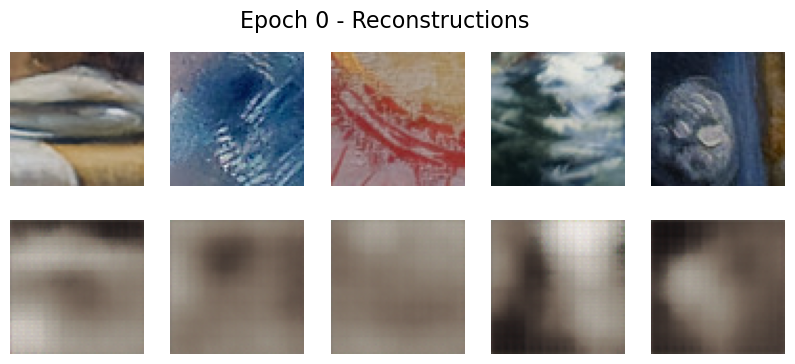

Epoch 1:   6%|▌         | 25/439 [00:24<06:51,  1.01batch/s, kld=778, loss=0.0872, recons_loss=0.0872]


KeyboardInterrupt: 

In [13]:
vae_model.train()

for epoch in range(n_epoch):
    train_loss = 0.0

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, _ in tepoch:  # Renommez 'data' en 'images' pour plus de clarté
            tepoch.set_description(f"Epoch {epoch}")

            # Mettre les données sur le bon périphérique
            images = images.to(device)  # Les images sont dans 'images', pas 'data'
            # Passer les images dans le modèle
            recons, input, mu, log_var = vae_model.forward(images)

            # Calculer la perte Beta-VAE
            losses = vae_model.loss_function(recons, input, mu, log_var)
            loss = losses['loss']
            recons_loss = losses['Reconstruction_Loss']
            kld = losses['KLD']
            
            # Backpropagation
            vae_model.zero_grad()
            loss.backward()
            optimizer.step()

            # Agréger la perte d'entraînement pour affichage à la fin de l'époque
            train_loss += loss.item()

            # Affichage de la barre tqdm avec la perte
            tepoch.set_postfix(loss=loss.item(), recons_loss=recons_loss.item(), kld=kld.item())


    # Affichage de la perte à la fin de l'époque
    print(f'Epoch {epoch}: Train Loss: {train_loss / len(train_loader):.4f}')

    # Afficher les reconstructions après chaque époque
    with torch.no_grad():  # Pas de calcul de gradients pour cette partie
        plot_reconstructions(images, recons, epoch)

In [12]:
recons

tensor(0.0750)

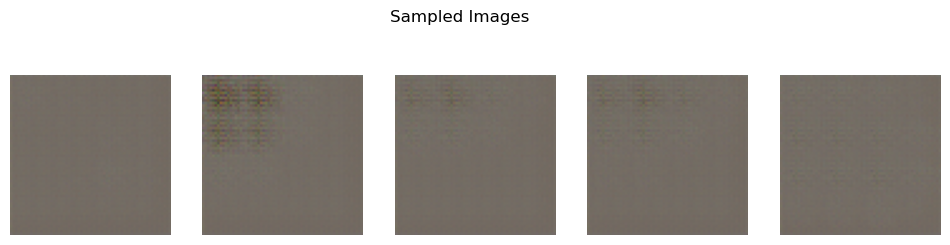

In [ ]:
# Plot the first 5 images in the 'samples' tensor
plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = samples[i].cpu().detach().numpy().transpose(1, 2, 0)
    plt.imshow((img + 1) / 2)  # Convert from [-1, 1] to [0, 1] for display if using Tanh
    plt.axis('off')
plt.suptitle('Sampled Images')
plt.show()